In [1]:
import nltk
from nltk.stem import WordNetLemmatizer
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import json

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [2]:
def load_data(path):
    # Load intents
    with open(path, 'r') as file:
        intents = json.load(file)['intents']

    intents_dict = {}
    response_dict = {}
    for intent in intents:
        intents_dict[intent['tag']] = intent['patterns']
        response_dict[intent['tag']] = intent['responses']

    return intents_dict, response_dict

In [3]:
intents_dict, response_dict = load_data('../clean_data/intents_enriched.json')
n_categories = len(intents_dict)
print(n_categories)

15


In [4]:
def process_intents(intents_dict):
    lemmatizer = WordNetLemmatizer()

    words = []
    intents = []
    words_tokenized = []
    ignore = ['?', '!', '.', ',']

    for intent in intents_dict:
        for pattern in intents_dict[intent]:
            w = nltk.tokenize.word_tokenize(pattern)
            words.extend(w) # append words from tokenized pattern to 'words'
            words_tokenized.append((w, intent)) # list of tuples containing list of words and intent class
            if intent not in intents:
                intents.append(intent) # unique list of intents

    # find base form of word and remove ignore words
    words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore]
    words = sorted(list(set(words))) # remove duplicates and sort

    intents = sorted(intents)

    return words, intents, words_tokenized

In [5]:
nltk.download('punkt')
nltk.download('wordnet')
# full list of unique words, intents, and tokenized words, paired with their
# associated intent class
words, intents, words_tokenized = process_intents(intents_dict)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rgbmr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rgbmr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Bag of words approach
<a id='bagofwords'></a>

In [6]:
def bag_of_words(words_tokenized, words, intents):
    lemmatizer = WordNetLemmatizer()
    features = []
    labels = []

    for pair in words_tokenized:
        words_encoded = []
        pattern_words = pair[0] # list of words
        # these words still need lemmatized
        pattern_words = [lemmatizer.lemmatize(word.lower()) for word in pattern_words]
        for w in words:
            # binary representation of whether each word is present in the pattern
            words_encoded.append(1 if w in pattern_words else 0)

        # make list of 0s with size = # of intents
        intents_encoded = [0] * len(intents)
        # set index of intent from sorted, unique list of intents to 1 in intents_encoded
        intents_encoded[intents.index(pair[1])] = 1 # pair[1] is the intent

        features.append(words_encoded)
        labels.append(intents_encoded)

    # ensures compatibility with numpy-based ML frameworks and enables batch processing
    features = np.array(features)
    labels = np.array(labels)

    return features, labels

In [7]:
# features, labels = bag_of_words(chosen_data, words, choices)
features, labels = bag_of_words(words_tokenized, words, intents)

Baseline model
<a id='baseline'></a>

In [8]:
class RNN(nn.Module):
    name = "RNN" # for keeping track of model type
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        self.ReLU = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, input, hidden):
        # Check that input size matches expected size
        if input.size(1) != self.i2o.in_features - self.hidden_size:
            raise ValueError("Input size mismatch: expected {}, got {}".format(
                self.i2o.in_features - self.hidden_size, input.size(1)
            ))
        combined = torch.cat((input, hidden), 1)
        # Ensure combined size matches linear layer input
        if combined.size(1) != self.i2o.in_features:
            raise RuntimeError("Concatenated size mismatch: expected {}, got {}".format(
                self.i2o.in_features, combined.size(1)
            ))
        hidden = self.i2o(combined)
        hidden = self.ReLU(hidden)
        hidden = self.dropout(hidden)
        output = self.softmax(hidden)
        return output, hidden

    def initHidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size).to(device)

In [9]:
learning_rate = 0.001

def train(model, category_tensor, line_tensor, criterion, optimizer):
    category_indices = category_tensor.argmax(dim=1)  # Convert to integer indices
    model.zero_grad()
    hidden = model.initHidden(line_tensor.size(0))
    output, _ = model(line_tensor.to(device), hidden)
    loss = criterion(output, category_indices)
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
    loss.backward()
    optimizer.step()
    return output, loss.item()

K-Folds Cross-Validation
<a id='kfolds'></a>

In [10]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch.optim as optim
import torch.utils.data as data

def train_and_validate(features, labels, n_hidden, learning_rate, batch_size, n_iters, model_type, n_splits):
    # Initialize KFold with n_splits
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    # Store results
    fold_accuracies = []
    fold_losses = []
    fold_f1 = []
    fold_precisions = []
    fold_recalls = []
    fold_val_accuracies = []  # For tracking validation accuracies
    fold_train_accuracies = []  # For tracking training accuracies

    input_size = len(features[0])
    output_size = len(labels[0])  # Number of intents

    for train_idx, test_idx in kf.split(features):
        # Create training and test datasets
        x_train = features[train_idx]
        y_train = labels[train_idx]
        x_test = features[test_idx]
        y_test = labels[test_idx]

        # Create DataLoaders for batching
        train_loader = data.DataLoader(data.TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train)), batch_size=batch_size, shuffle=True, drop_last=True)
        test_loader = data.DataLoader(data.TensorDataset(torch.from_numpy(x_test), torch.from_numpy(y_test)), batch_size=batch_size, shuffle=False, drop_last=True)

        # Initialize a new model for each fold
        model = model_type(input_size, n_hidden, output_size)

        # Move the model to the correct device
        model.to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)

        # Reset loss tracking for each fold
        epoch_losses = []
        train_accuracies = []  # Reset train accuracies
        test_accuracies = []  # Reset test accuracies

        # Training loop for the current fold
        for epoch in range(n_iters):
            running_loss = 0.0
            correct = 0
            total = 0
            for line_tensor, category_tensor in train_loader:
                line_tensor = line_tensor.to(device)
                category_tensor = category_tensor.to(device)

                model.zero_grad()  # Reset gradients

                hidden = model.initHidden(line_tensor.size(0))
                output, hidden = model(line_tensor, hidden)

                loss = criterion(output, category_tensor.argmax(dim=1))  # Assuming one-hot encoded labels
                running_loss += loss.item()  # Track total loss
                loss.backward()  # Backward pass
                optimizer.step()  # Update weights

                _, predicted = output.max(1)  # Get predictions
                total += category_tensor.size(0)  # Total samples
                correct += (predicted == category_tensor.argmax(dim=1)).sum().item()  # Correct predictions

            # Calculate average loss and accuracy for this epoch
            epoch_loss = running_loss / len(train_loader)
            epoch_accuracy = correct / total

            # Store loss and training accuracy
            epoch_losses.append(epoch_loss)
            train_accuracies.append(epoch_accuracy)

            # Evaluate on the test set
            model.eval()  # Set the model to evaluation mode
            with torch.no_grad():
                correct_val = 0
                total_val = 0
                for line_tensor, category_tensor in test_loader:
                    line_tensor = line_tensor.to(device)
                    category_tensor = category_tensor.to(device)
                    hidden = model.initHidden(line_tensor.size(0)) # Initialize hidden state
                    output, hidden = model(line_tensor, hidden) # get output
                    _, preds = output.max(1)  # Get predictions
                    total_val += category_tensor.size(0)  # Total samples
                    correct_val += (preds == category_tensor.argmax(dim=1)).sum().item()  # Correct predictions

            # Calculate validation accuracy while training to monitor overfitting
            val_accuracy = correct_val / total_val
            test_accuracies.append(val_accuracy)
            if epoch % 10 == 0:
                print(f"Epoch {epoch + 1}/{n_iters}, Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy * 100:.2f}%, Validation Accuracy: {val_accuracy * 100:.2f}%")

        # Store results for this fold
        fold_losses.append(epoch_losses)
        fold_train_accuracies.append(train_accuracies)
        fold_val_accuracies.append(test_accuracies)

        # Calculate final accuracy for the current fold
        model.eval()
        all_preds = []
        all_targets = []
        with torch.no_grad():
            for line_tensor, category_tensor in test_loader:
                line_tensor = line_tensor.to(device)
                category_tensor = category_tensor.to(device)

                hidden = model.initHidden(line_tensor.size(0))
                output, hidden = model(line_tensor, hidden)

                _, preds = output.max(1)  # Get predictions
                all_preds.extend(preds.cpu().numpy())
                all_targets.extend(category_tensor.cpu().numpy())

        # Calculate test accuracy, precision, recall, and F1 score
        accuracy = accuracy_score([np.argmax(y) for y in all_targets], [np.argmax(p) for p in all_preds])
        precision = precision_score([np.argmax(y) for y in all_targets], [np.argmax(p) for p in all_preds], average="weighted")
        recall = recall_score([np.argmax(y) for y in all_targets], [np.argmax(p) for p in all_preds], average="weighted")
        f1 = f1_score([np.argmax(y) for y in all_targets], [np.argmax(p) for p in all_preds], average="weighted")

        fold_accuracies.append(accuracy)
        fold_precisions.append(precision)
        fold_recalls.append(recall)
        fold_f1.append(f1)

        print(f"Final Test Accuracy for this fold: {accuracy * 100:.2f}%")

    # Calculate the average results across all folds
    average_accuracy = np.mean(fold_accuracies)
    average_precision = np.mean(fold_precisions)
    average_recall = np.mean(fold_recalls)
    average_f1 = np.mean(fold_f1)

    print("Average Test Accuracy across all folds:", average_accuracy * 100)
    print("Average Test Precision across all folds:", average_precision * 100)
    print("Average Test Recall across all folds:", average_recall * 100)
    print("Average Test F1 Score across all folds:", average_f1 * 100)

    return model, average_accuracy, fold_losses, fold_train_accuracies, fold_val_accuracies

In [17]:
# first trial: n_hidden = 128, learning_rate = 0.001, batch_size = 10, n_iters = 100
# second trial: n_hidden = 256, learning_rate = 0.001, batch_size = 10, n_iters = 100; val accuracy still going up
model, accuracy, losses, train_accuracies, test_accuracies = train_and_validate(features, labels, 256, learning_rate, 10, 200, RNN, 5)

Epoch 1/200, Loss: 2.6428, Train Accuracy: 28.82%, Validation Accuracy: 54.88%
Epoch 11/200, Loss: 1.6208, Train Accuracy: 61.05%, Validation Accuracy: 59.26%
Epoch 21/200, Loss: 1.3066, Train Accuracy: 62.85%, Validation Accuracy: 60.58%
Epoch 31/200, Loss: 1.1337, Train Accuracy: 71.28%, Validation Accuracy: 68.68%
Epoch 41/200, Loss: 1.0200, Train Accuracy: 75.57%, Validation Accuracy: 72.64%
Epoch 51/200, Loss: 0.9349, Train Accuracy: 79.18%, Validation Accuracy: 76.78%
Epoch 61/200, Loss: 0.8665, Train Accuracy: 80.66%, Validation Accuracy: 78.93%
Epoch 71/200, Loss: 0.8101, Train Accuracy: 82.37%, Validation Accuracy: 80.50%
Epoch 81/200, Loss: 0.7637, Train Accuracy: 83.90%, Validation Accuracy: 81.98%
Epoch 91/200, Loss: 0.7249, Train Accuracy: 85.11%, Validation Accuracy: 83.14%
Epoch 101/200, Loss: 0.6904, Train Accuracy: 86.02%, Validation Accuracy: 83.47%
Epoch 111/200, Loss: 0.6617, Train Accuracy: 86.70%, Validation Accuracy: 84.71%
Epoch 121/200, Loss: 0.6347, Train Accu

c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Final Test Accuracy for this fold: 4.30%
Epoch 1/200, Loss: 2.6418, Train Accuracy: 26.72%, Validation Accuracy: 47.44%
Epoch 11/200, Loss: 1.6571, Train Accuracy: 61.15%, Validation Accuracy: 59.01%
Epoch 21/200, Loss: 1.3700, Train Accuracy: 62.78%, Validation Accuracy: 60.83%
Epoch 31/200, Loss: 1.2233, Train Accuracy: 67.15%, Validation Accuracy: 65.12%
Epoch 41/200, Loss: 1.1278, Train Accuracy: 68.54%, Validation Accuracy: 65.87%
Epoch 51/200, Loss: 1.0547, Train Accuracy: 70.66%, Validation Accuracy: 68.18%
Epoch 61/200, Loss: 0.9977, Train Accuracy: 75.63%, Validation Accuracy: 73.14%
Epoch 71/200, Loss: 0.9507, Train Accuracy: 77.69%, Validation Accuracy: 75.12%
Epoch 81/200, Loss: 0.9100, Train Accuracy: 79.34%, Validation Accuracy: 77.36%
Epoch 91/200, Loss: 0.8754, Train Accuracy: 80.58%, Validation Accuracy: 78.93%
Epoch 101/200, Loss: 0.8455, Train Accuracy: 82.23%, Validation Accuracy: 80.08%
Epoch 111/200, Loss: 0.8181, Train Accuracy: 82.80%, Validation Accuracy: 80.50

c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Final Test Accuracy for this fold: 3.88%
Epoch 1/200, Loss: 2.6060, Train Accuracy: 38.72%, Validation Accuracy: 54.79%
Epoch 11/200, Loss: 1.6197, Train Accuracy: 60.08%, Validation Accuracy: 62.07%
Epoch 21/200, Loss: 1.3013, Train Accuracy: 62.52%, Validation Accuracy: 63.88%
Epoch 31/200, Loss: 1.1248, Train Accuracy: 72.89%, Validation Accuracy: 72.81%
Epoch 41/200, Loss: 1.0036, Train Accuracy: 78.45%, Validation Accuracy: 78.35%
Epoch 51/200, Loss: 0.9107, Train Accuracy: 80.41%, Validation Accuracy: 80.08%
Epoch 61/200, Loss: 0.8405, Train Accuracy: 82.43%, Validation Accuracy: 82.64%
Epoch 71/200, Loss: 0.7791, Train Accuracy: 84.12%, Validation Accuracy: 83.97%
Epoch 81/200, Loss: 0.7291, Train Accuracy: 85.46%, Validation Accuracy: 85.54%
Epoch 91/200, Loss: 0.6865, Train Accuracy: 87.11%, Validation Accuracy: 86.53%
Epoch 101/200, Loss: 0.6483, Train Accuracy: 88.35%, Validation Accuracy: 88.10%
Epoch 111/200, Loss: 0.6150, Train Accuracy: 89.13%, Validation Accuracy: 89.09

c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Final Test Accuracy for this fold: 4.30%
Epoch 1/200, Loss: 2.6451, Train Accuracy: 23.34%, Validation Accuracy: 37.19%
Epoch 11/200, Loss: 1.6666, Train Accuracy: 59.98%, Validation Accuracy: 62.48%
Epoch 21/200, Loss: 1.3242, Train Accuracy: 61.88%, Validation Accuracy: 64.88%
Epoch 31/200, Loss: 1.1458, Train Accuracy: 71.38%, Validation Accuracy: 73.22%
Epoch 41/200, Loss: 1.0224, Train Accuracy: 75.13%, Validation Accuracy: 76.45%
Epoch 51/200, Loss: 0.9281, Train Accuracy: 78.70%, Validation Accuracy: 80.08%
Epoch 61/200, Loss: 0.8548, Train Accuracy: 81.32%, Validation Accuracy: 81.98%
Epoch 71/200, Loss: 0.7926, Train Accuracy: 84.21%, Validation Accuracy: 84.79%
Epoch 81/200, Loss: 0.7396, Train Accuracy: 86.02%, Validation Accuracy: 86.36%
Epoch 91/200, Loss: 0.6954, Train Accuracy: 87.65%, Validation Accuracy: 87.77%
Epoch 101/200, Loss: 0.6558, Train Accuracy: 88.60%, Validation Accuracy: 88.51%
Epoch 111/200, Loss: 0.6208, Train Accuracy: 89.71%, Validation Accuracy: 89.42

c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Final Test Accuracy for this fold: 3.22%
Epoch 1/200, Loss: 2.6256, Train Accuracy: 34.64%, Validation Accuracy: 55.37%
Epoch 11/200, Loss: 1.6412, Train Accuracy: 60.66%, Validation Accuracy: 60.00%
Epoch 21/200, Loss: 1.3296, Train Accuracy: 61.53%, Validation Accuracy: 60.83%
Epoch 31/200, Loss: 1.1510, Train Accuracy: 69.11%, Validation Accuracy: 70.17%
Epoch 41/200, Loss: 1.0283, Train Accuracy: 75.03%, Validation Accuracy: 75.29%
Epoch 51/200, Loss: 0.9334, Train Accuracy: 79.07%, Validation Accuracy: 78.35%
Epoch 61/200, Loss: 0.8582, Train Accuracy: 82.25%, Validation Accuracy: 81.40%
Epoch 71/200, Loss: 0.7951, Train Accuracy: 83.86%, Validation Accuracy: 83.31%
Epoch 81/200, Loss: 0.7408, Train Accuracy: 85.05%, Validation Accuracy: 84.96%
Epoch 91/200, Loss: 0.6958, Train Accuracy: 86.70%, Validation Accuracy: 86.61%
Epoch 101/200, Loss: 0.6558, Train Accuracy: 88.10%, Validation Accuracy: 88.26%
Epoch 111/200, Loss: 0.6207, Train Accuracy: 89.09%, Validation Accuracy: 89.59

c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [12]:
def plot_losses(fold_losses):
    plt.figure(figsize=(10, 6))  # Set the plot size
    for fold_idx, losses in enumerate(fold_losses):
        plt.plot(losses, label=f'Fold {fold_idx + 1}')  # Plot each fold's loss

    # Add titles and labels
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss over Time")
    plt.legend()  # Add a legend for the plot
    plt.show()  # Display the plot

In [13]:
import matplotlib.ticker as ticker

def make_confusion(model, intents, features, labels, n_categories, n_samples=10000):
    # Initialize the confusion matrix
    confusion = torch.zeros(n_categories, n_categories).to(device)

    # Define the evaluation function
    def evaluate(line_tensor):
        hidden = model.initHidden(line_tensor.size(0))
        output, hidden = model(line_tensor, hidden)
        return output

    # Collect test samples for creating the confusion matrix
    test_indices = np.random.choice(len(features), n_samples, replace=True)  # Random test samples

    for i in test_indices:
        # Convert the sample to tensor
        line_tensor = torch.from_numpy(features[i]).unsqueeze(0).to(device)  # Add batch dimension
        category_tensor = torch.from_numpy(labels[i]).to(device)

        output = evaluate(line_tensor)
        guess, guess_i = output.max(1)  # Get predictions
        category_i = category_tensor.argmax().item()  # Convert one-hot to class index

        confusion[category_i][guess_i] += 1

    # Normalize the confusion matrix
    for i in range(n_categories):
        if confusion[i].sum() > 0:
            confusion[i] = confusion[i] / confusion[i].sum()

    # Plot the confusion matrix
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion.cpu().numpy())
    fig.colorbar(cax)

    # Set up axes labels
    ax.set_xticklabels([''] + intents, rotation=90)
    ax.set_yticklabels([''] + intents)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # Set the axis labels
    plt.xlabel("Predicted Labels")  # Horizontal axis for predicted labels
    plt.ylabel("True Labels")  # Vertical axis for true labels

    plt.show()

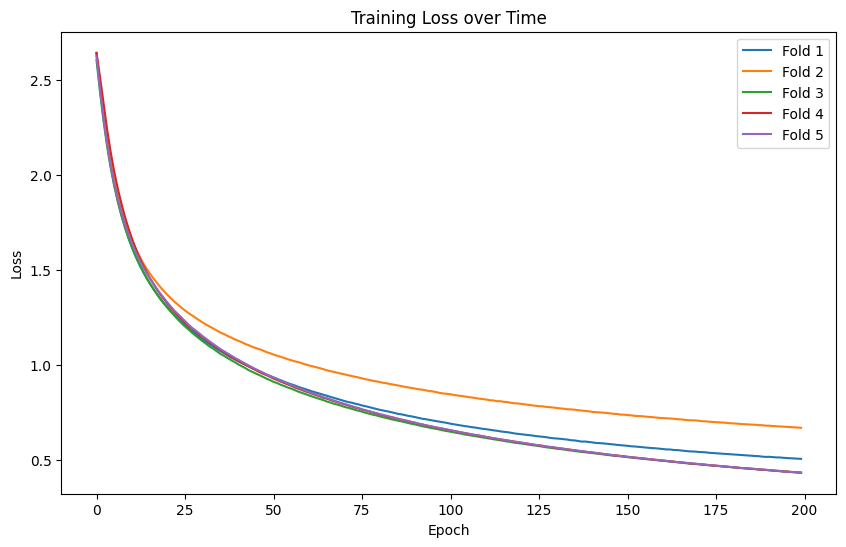

In [18]:
plot_losses(losses)

C:\Users\rgbmr\AppData\Local\Temp\ipykernel_11336\848338305.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + intents, rotation=90)
C:\Users\rgbmr\AppData\Local\Temp\ipykernel_11336\848338305.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + intents)


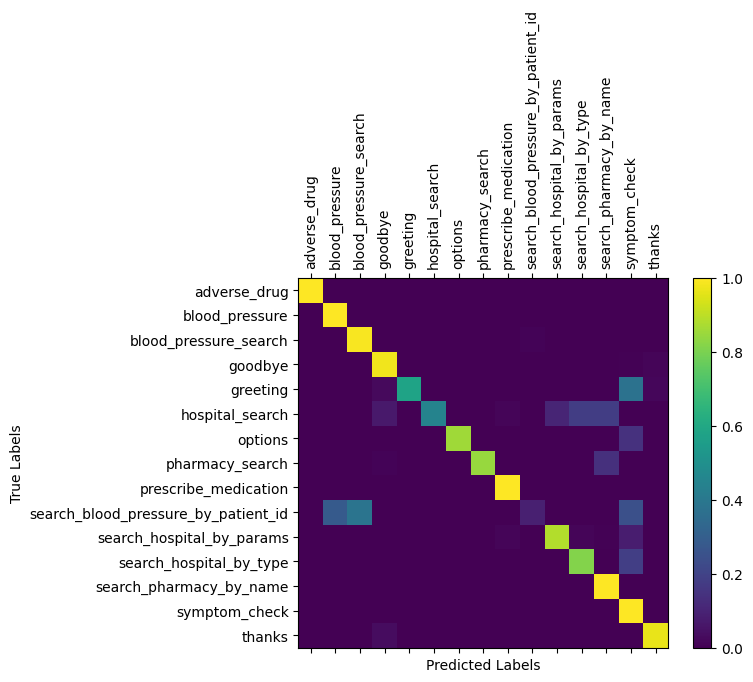

In [19]:
make_confusion(model, intents, features, labels, n_categories)

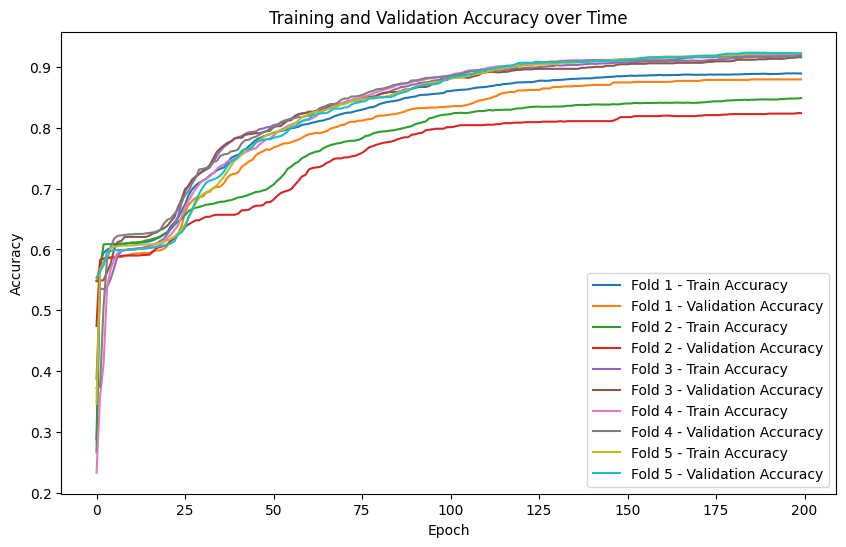

In [20]:
def plot_accuracies(fold_train_accuracies, fold_val_accuracies):
    plt.figure(figsize=(10, 6))  # Set the plot size
    for fold_idx in range(len(fold_train_accuracies)):
        plt.plot(
            fold_train_accuracies[fold_idx],
            label=f'Fold {fold_idx + 1} - Train Accuracy'
        )
        plt.plot(
            fold_val_accuracies[fold_idx],
            label=f'Fold {fold_idx + 1} - Validation Accuracy'
        )

    # Add titles and labels
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy over Time")
    plt.legend()  # Add a legend to distinguish train/validation accuracies
    plt.show()  # Display the plot

plot_accuracies(train_accuracies, test_accuracies)

Class imbalance. Classes 4 (greeting) and 5 (hospital_search) are especially under-represented

In [21]:
from collections import Counter
import numpy as np

def show_distribution(features, labels):
    # Example: Convert one-hot encoded vectors to class indices
    all_fold_distributions = []

    kf = KFold(n_splits=5, shuffle=True, random_state=1)

    for train_idx, test_idx in kf.split(features):
        # Convert one-hot encoded labels to class indices
        class_indices = np.argmax(labels[train_idx], axis=1)  # Convert to class indices

        # Calculate class distribution in the training set
        fold_train_classes = Counter(class_indices)  # Counter expects hashable types
        all_fold_distributions.append(fold_train_classes)

    # Display class distributions for each fold
    for fold_idx, distribution in enumerate(all_fold_distributions):
        print(f"Class distribution in fold {fold_idx + 1} (train):", distribution)

In [22]:
show_distribution(features, labels)

Class distribution in fold 1 (train): Counter({2: 1025, 3: 904, 8: 712, 13: 486, 1: 313, 9: 223, 14: 207, 12: 198, 0: 188, 10: 151, 7: 120, 6: 106, 4: 80, 11: 74, 5: 70})
Class distribution in fold 2 (train): Counter({2: 998, 3: 918, 8: 729, 13: 484, 1: 308, 9: 232, 12: 201, 0: 193, 14: 189, 10: 159, 7: 119, 6: 95, 11: 82, 4: 77, 5: 73})
Class distribution in fold 3 (train): Counter({2: 1008, 3: 892, 8: 722, 13: 479, 1: 322, 9: 227, 14: 214, 12: 195, 0: 188, 10: 162, 7: 119, 6: 108, 4: 78, 11: 75, 5: 69})
Class distribution in fold 4 (train): Counter({2: 985, 3: 898, 8: 727, 13: 483, 1: 320, 9: 231, 12: 205, 0: 201, 14: 192, 10: 161, 7: 126, 6: 95, 11: 86, 5: 75, 4: 73})
Class distribution in fold 5 (train): Counter({2: 1024, 3: 908, 8: 710, 13: 468, 1: 301, 9: 239, 14: 210, 12: 201, 0: 190, 10: 151, 7: 116, 6: 108, 11: 83, 4: 76, 5: 73})


In [23]:
intents

['adverse_drug',
 'blood_pressure',
 'blood_pressure_search',
 'goodbye',
 'greeting',
 'hospital_search',
 'options',
 'pharmacy_search',
 'prescribe_medication',
 'search_blood_pressure_by_patient_id',
 'search_hospital_by_params',
 'search_hospital_by_type',
 'search_pharmacy_by_name',
 'symptom_check',
 'thanks']

Evening out distribution by oversampling
<a id='sampling'></a>

In [24]:
from imblearn.over_sampling import RandomOverSampler

# Oversample minority classes or undersample majority classes
def over_under_sample(features, labels, sampler):
    features_oversampled, labels_indices = sampler.fit_resample(features, np.argmax(labels, axis=1))

    # Convert the class indices back to one-hot encoding
    num_classes = labels.shape[1]  # Determine the number of classes
    labels_oversampled = np.eye(num_classes)[labels_indices]  # Convert class indices back to one-hot encoding

    show_distribution(features_oversampled, labels_oversampled)

    return features_oversampled, labels_oversampled

In [25]:
ros = RandomOverSampler(random_state=1)
features_oversampled, labels_oversampled = over_under_sample(features, labels, ros)

Class distribution in fold 1 (train): Counter({6: 1033, 9: 1027, 3: 1022, 0: 1022, 1: 1021, 5: 1021, 10: 1012, 14: 1008, 2: 1008, 4: 1000, 7: 998, 12: 992, 13: 991, 8: 987, 11: 978})
Class distribution in fold 2 (train): Counter({0: 1033, 14: 1031, 8: 1022, 12: 1020, 11: 1019, 10: 1017, 2: 1016, 1: 1013, 6: 1003, 3: 1002, 13: 1001, 5: 995, 4: 988, 7: 986, 9: 974})
Class distribution in fold 3 (train): Counter({0: 1023, 4: 1022, 8: 1021, 2: 1016, 12: 1014, 1: 1012, 3: 1011, 13: 1009, 5: 1005, 9: 1004, 7: 1004, 14: 1001, 11: 1001, 6: 994, 10: 983})
Class distribution in fold 4 (train): Counter({9: 1019, 5: 1019, 11: 1015, 7: 1012, 1: 1011, 13: 1011, 10: 1010, 8: 1010, 3: 1007, 4: 1006, 12: 1005, 14: 1003, 2: 1002, 6: 997, 0: 993})
Class distribution in fold 5 (train): Counter({7: 1040, 13: 1028, 11: 1027, 4: 1024, 10: 1018, 9: 1016, 6: 1013, 12: 1009, 5: 1000, 8: 1000, 3: 998, 2: 998, 14: 997, 1: 983, 0: 969})


Oversampling provides a marked improvement to model test accuracy

In [26]:
model, accuracy, losses, train_accuracies, test_accuracies = train_and_validate(features_oversampled, labels_oversampled, 128, learning_rate, 10, 100, RNN, 5)

Epoch 1/100, Loss: 2.6482, Train Accuracy: 34.01%, Validation Accuracy: 57.38%
Epoch 11/100, Loss: 1.6001, Train Accuracy: 85.30%, Validation Accuracy: 85.77%
Epoch 21/100, Loss: 1.1486, Train Accuracy: 86.57%, Validation Accuracy: 86.75%
Epoch 31/100, Loss: 0.9227, Train Accuracy: 88.45%, Validation Accuracy: 88.44%
Epoch 41/100, Loss: 0.7896, Train Accuracy: 88.98%, Validation Accuracy: 88.84%
Epoch 51/100, Loss: 0.7018, Train Accuracy: 89.12%, Validation Accuracy: 88.99%
Epoch 61/100, Loss: 0.6390, Train Accuracy: 89.17%, Validation Accuracy: 89.15%
Epoch 71/100, Loss: 0.5918, Train Accuracy: 89.32%, Validation Accuracy: 89.21%
Epoch 81/100, Loss: 0.5548, Train Accuracy: 89.57%, Validation Accuracy: 89.29%
Epoch 91/100, Loss: 0.5250, Train Accuracy: 90.20%, Validation Accuracy: 90.08%


c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Final Test Accuracy for this fold: 6.30%
Epoch 1/100, Loss: 2.6563, Train Accuracy: 33.74%, Validation Accuracy: 59.63%
Epoch 11/100, Loss: 1.5358, Train Accuracy: 86.46%, Validation Accuracy: 85.87%
Epoch 21/100, Loss: 1.0427, Train Accuracy: 89.35%, Validation Accuracy: 87.72%
Epoch 31/100, Loss: 0.7956, Train Accuracy: 90.82%, Validation Accuracy: 89.81%
Epoch 41/100, Loss: 0.6509, Train Accuracy: 91.59%, Validation Accuracy: 90.71%
Epoch 51/100, Loss: 0.5563, Train Accuracy: 91.78%, Validation Accuracy: 90.90%
Epoch 61/100, Loss: 0.4896, Train Accuracy: 91.82%, Validation Accuracy: 90.98%
Epoch 71/100, Loss: 0.4398, Train Accuracy: 92.31%, Validation Accuracy: 91.46%
Epoch 81/100, Loss: 0.4010, Train Accuracy: 92.37%, Validation Accuracy: 91.53%
Epoch 91/100, Loss: 0.3699, Train Accuracy: 93.10%, Validation Accuracy: 91.93%


c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Final Test Accuracy for this fold: 6.01%
Epoch 1/100, Loss: 2.6598, Train Accuracy: 31.10%, Validation Accuracy: 52.80%
Epoch 11/100, Loss: 1.8533, Train Accuracy: 70.42%, Validation Accuracy: 70.77%
Epoch 21/100, Loss: 1.3951, Train Accuracy: 77.50%, Validation Accuracy: 77.30%
Epoch 31/100, Loss: 1.1539, Train Accuracy: 79.70%, Validation Accuracy: 79.95%
Epoch 41/100, Loss: 1.0146, Train Accuracy: 80.71%, Validation Accuracy: 80.71%
Epoch 51/100, Loss: 0.9231, Train Accuracy: 80.85%, Validation Accuracy: 80.82%
Epoch 61/100, Loss: 0.8578, Train Accuracy: 80.96%, Validation Accuracy: 80.90%
Epoch 71/100, Loss: 0.8086, Train Accuracy: 81.02%, Validation Accuracy: 80.90%
Epoch 81/100, Loss: 0.7700, Train Accuracy: 81.10%, Validation Accuracy: 81.16%
Epoch 91/100, Loss: 0.7389, Train Accuracy: 81.73%, Validation Accuracy: 81.72%


c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Final Test Accuracy for this fold: 6.27%
Epoch 1/100, Loss: 2.6628, Train Accuracy: 27.47%, Validation Accuracy: 51.16%
Epoch 11/100, Loss: 1.6191, Train Accuracy: 84.56%, Validation Accuracy: 85.61%
Epoch 21/100, Loss: 1.1599, Train Accuracy: 85.91%, Validation Accuracy: 86.96%
Epoch 31/100, Loss: 0.9292, Train Accuracy: 87.86%, Validation Accuracy: 88.49%
Epoch 41/100, Loss: 0.7057, Train Accuracy: 90.34%, Validation Accuracy: 91.35%
Epoch 51/100, Loss: 0.5882, Train Accuracy: 91.38%, Validation Accuracy: 92.30%
Epoch 61/100, Loss: 0.5121, Train Accuracy: 91.48%, Validation Accuracy: 92.41%
Epoch 71/100, Loss: 0.4571, Train Accuracy: 91.53%, Validation Accuracy: 92.41%
Epoch 81/100, Loss: 0.4151, Train Accuracy: 91.67%, Validation Accuracy: 92.78%
Epoch 91/100, Loss: 0.3818, Train Accuracy: 92.86%, Validation Accuracy: 93.52%


c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Final Test Accuracy for this fold: 7.06%
Epoch 1/100, Loss: 2.6499, Train Accuracy: 34.54%, Validation Accuracy: 64.07%
Epoch 11/100, Loss: 1.5908, Train Accuracy: 86.04%, Validation Accuracy: 87.12%
Epoch 21/100, Loss: 1.0687, Train Accuracy: 88.41%, Validation Accuracy: 89.39%
Epoch 31/100, Loss: 0.8111, Train Accuracy: 90.46%, Validation Accuracy: 91.46%
Epoch 41/100, Loss: 0.6622, Train Accuracy: 91.30%, Validation Accuracy: 92.41%
Epoch 51/100, Loss: 0.5653, Train Accuracy: 91.42%, Validation Accuracy: 92.46%
Epoch 61/100, Loss: 0.4972, Train Accuracy: 91.48%, Validation Accuracy: 92.49%
Epoch 71/100, Loss: 0.4464, Train Accuracy: 91.73%, Validation Accuracy: 92.70%
Epoch 81/100, Loss: 0.4069, Train Accuracy: 92.93%, Validation Accuracy: 93.57%
Epoch 91/100, Loss: 0.3752, Train Accuracy: 94.00%, Validation Accuracy: 94.44%
Final Test Accuracy for this fold: 7.70%
Average Test Accuracy across all folds: 6.666666666666667
Average Test Precision across all folds: 0.4483525097281711
A

c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


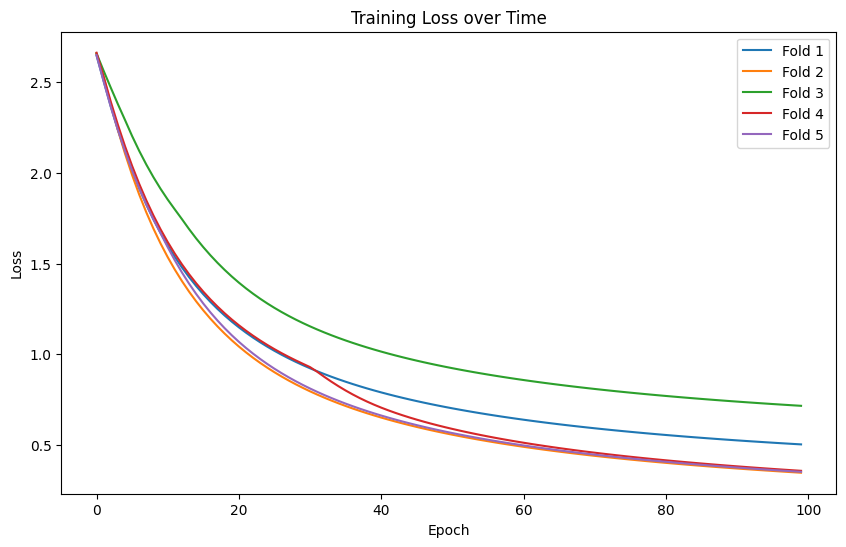

In [27]:
plot_losses(losses)

C:\Users\rgbmr\AppData\Local\Temp\ipykernel_11336\848338305.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + intents, rotation=90)
C:\Users\rgbmr\AppData\Local\Temp\ipykernel_11336\848338305.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + intents)


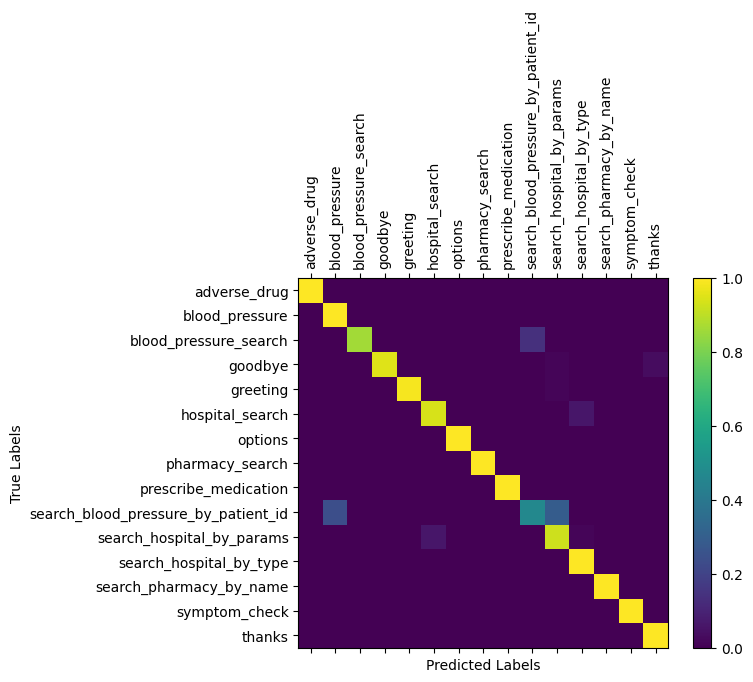

In [28]:
make_confusion(model, intents, features_oversampled, labels_oversampled, n_categories)

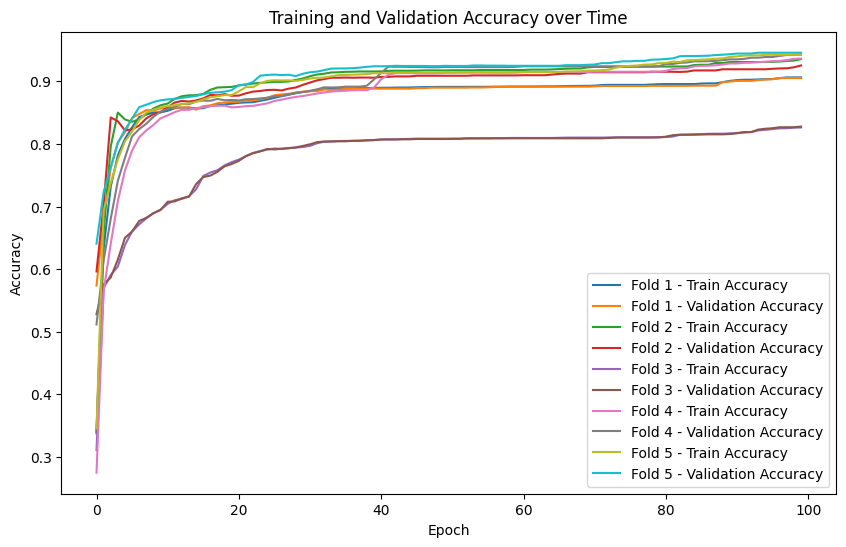

In [29]:
plot_accuracies(train_accuracies, test_accuracies)

In [30]:
def predict(model, input_line, words, n_predictions=3):
    # Just return an output given a line
    def evaluate(line_tensor):
        hidden = model.initHidden(line_tensor.size(0))
        output, hidden = model(line_tensor, hidden)

        return output
    
    def words_in_bag(sentence):
        lemmatizer = WordNetLemmatizer()
        if sentence is None:
            return np.zeros(len(words))
        sentence_words = nltk.tokenize.word_tokenize(sentence)
        sentence_words = [lemmatizer.lemmatize(word.lower()) for word in sentence_words]
        bag = [0] * len(words)
        for s in sentence_words:
            for i, w in enumerate(words):
                if w == s:
                    bag[i] = 1
        return np.array(bag)
    
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(torch.from_numpy(words_in_bag(input_line)).view(1, -1))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, intents[category_index]))
            predictions.append([value, intents[category_index]])

In [32]:
predict(model, 'Can you help me?', words)


> Can you help me?
(-0.26) options
(-2.70) thanks
(-3.75) goodbye


In [33]:
# Save the model
torch.save(model, '../clean_data/models/intents_classifier.pth')